<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/RNN_For_1D_Colored_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Main Goals

1. What is the best RNN cell to predeict Colored noise?
2. What is the best hyperparameters configuration for each cell?
3. Is the `mse` the best loss function? Can we inplement the $\beta$ long term analyse? 
4. What about `deepAR`, `Arima`, `Prophet`, [`WaveNet`](https://homl.info/wavenet) and `Transformer`?
5. What about [`LSTMAutoencoder`](https://www.youtube.com/watch?v=6S2v7G-OupA)? 
6. Explore several hyperparamntes using [OPTUNA](https://optuna.org/)
 * Number of layers 
 * Number of Neurons
 * Activation functions

# Some questions:

*  Is the `look_back` to long? Add inicial 1D convolutional layer?
*  

# Doctor Sauter Sugestions 

* Make the prediction the FFT signal

## Downloading data

In [1]:
#Monting Google Drive
#https://medium.com/analyatics-vidhya/how-to-download-kaggle-datasets-into-google-colab-via-google-drive-dcb348d7af07
from google.colab import drive
drive.mount('/content/drive')
#Importing and conifg the Kaggle Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
# Acessing the folder
%cd /content/drive/MyDrive/Kaggle/
# Dowloading NASA data-set
!kaggle datasets download -d luanorionbarana/synthetic-colored-noise
#Unziping data-set
!unzip "synthetic-colored-noise.zip" -d "/content/"

Mounted at /content/drive
/content/drive/MyDrive/Kaggle
 99% 1.15G/1.16G [00:09<00:00, 123MB/s]
100% 1.16G/1.16G [00:10<00:00, 124MB/s]
Archive:  synthetic-colored-noise.zip
  inflating: /content/color.csv      
  inflating: /content/color.plk      
  inflating: /content/color_4series.plk  


In [2]:
# #Retorning to Sample folder! NOT NECESSERY
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content


# Librarys

In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, LSTM, GRU, RNN,SimpleRNN, InputLayer,Conv1D, add, Reshape, Flatten
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
#from datetime import datetime # for put the time info in each plot          #https://stackoverflow.com/questions/415511/how-to-get-the-current-time-in-python
import time as time

## Ploting

In [5]:
df = pd.read_pickle('color_4series.plk')

Text(0, 0.5, 'Amplitude')

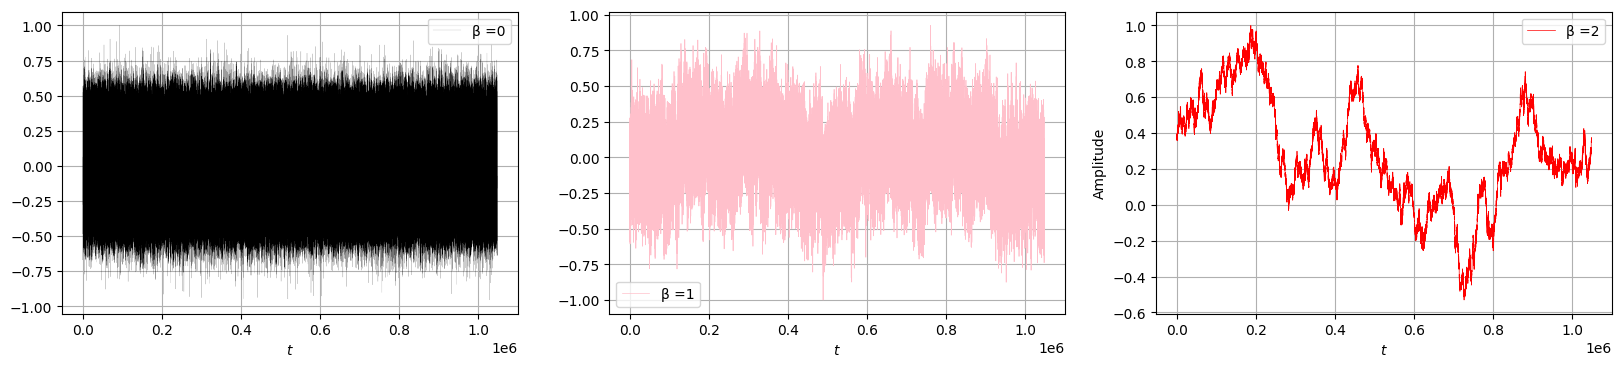

In [3]:
index = [0,4,9]
color = ['black','pink','red']
linewidth = [0.07,0.5,.5]
plt.figure(figsize=(20,4),dpi=100)
for i in range(len(index)):
  plt.subplot(1,3,i+1)
  plt.plot(df.Series[index[i]][:],label='β ='+str(df.beta[index[i]]),color=color[i],linewidth=linewidth[i])
  plt.grid()
  plt.legend()
  plt.xlabel('$t$')
plt.ylabel('Amplitude')
  #plt.title(color[i]+ ' noise')
#plt.suptitle('Colored Noise')


# Pre-processing

In [ ]:
# Mesuring time ⏱️
begin = time.time()

In [3]:
path = "/content/drive/MyDrive/INPE/Qualification"

In [6]:
serie_index = 0  #white Noise
#serie_index = 4 #pink noise
#serie_index =  9#red Noise

min_size , max_size = 0 , len(df.Series[0])

dataframe = pd.DataFrame({"Serie":df['Series'][serie_index][min_size:max_size]})
dataset = dataframe.values.astype('float32')
beta = str(df['beta'][serie_index])

In [7]:
# definindo as amostras de treinamento e teste segundo o hold-out.
train_size = int(len(dataset) * 0.50)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [8]:
# conversão da série temporal em uma matriz de atributos para regressão
def create_dataset(dataset, look_back=10):
	'''
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the look_back is equal to 3 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3]
  dataX[1] = [1,2,3] ; dataY[1] = [4]
  dataX[2] = [2,3,4] ; dataY[2] = [5]
  dataX[3] = [3,4,5] ; dataY[3] = [6]
	'''
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [9]:
look_back = 2**10

trainX, trainY = create_dataset(train, look_back)
testX, testY   = create_dataset(test,  look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX,(trainX.shape[0],1, trainX.shape[1]))
testX =  np.reshape(testX, (testX.shape[0],1, testX.shape[1]))
#valX =   np.reshape(valX,  (valX.shape[0],  1, valX.shape[1]))

# Model

In [10]:
#Setting Random seeds🌱
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(3)

In [11]:
#Paramenters 
epochs = 2
batch_size = 256#len(trainX)# 256#
model_code = 'test'#All_layers_Bacth256'
n_1 = 64#10#int(look_back*100)
n_2 = 64#int(look_back*100)
n_3 = 64 #int(look_back*1e-1)
n_4 = 64#10#int(look_back*1e-1)

## Simple RNN

In [12]:
star_RNN = time.time()
model_RNN = Sequential()
#model_RNN.add(SimpleRNN(n_1,input_shape=(1,look_back)))
model_RNN.add(SimpleRNN(n_1, return_sequences=True,input_shape=(1,look_back)))
model_RNN.add(SimpleRNN(n_2, return_sequences=True))
model_RNN.add(SimpleRNN(n_3, return_sequences=True))
model_RNN.add(SimpleRNN(n_4))
model_RNN.add(Dense(1))
model_RNN.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_RNN = model_RNN.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.7)
#model_RNN.save('model_RNN')
time_RNN = time.time()

Epoch 1/2
614/614 [==============================] - 16s 22ms/step - loss: 0.0443 - mse: 0.0443 - val_loss: 0.0433 - val_mse: 0.0433
Epoch 2/2
614/614 [==============================] - 12s 19ms/step - loss: 0.0432 - mse: 0.0432 - val_loss: 0.0432 - val_mse: 0.0432


## LSTM

In [13]:
star_LSTM = time.time()
model_LSTM = Sequential()
#model_LSTM.add(LSTM(n_1, input_shape=(1,look_back)))
model_LSTM.add(LSTM(n_1, return_sequences=True,input_shape=(1,look_back)))
model_LSTM.add(LSTM(n_2, return_sequences=True))
model_LSTM.add(LSTM(n_3, return_sequences=True))
model_LSTM.add(LSTM(n_4))
model_LSTM.add(Dense(1))
model_LSTM.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_LSTM = model_LSTM.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.7)
time_LSTM = time.time()
#model_LSTM.save('model_LSTM')
#!zip -r /content/drive/MyDrive/Kaggle/model_LSTM.zip /content/model_LSTM/

Epoch 1/2
614/614 [==============================] - 38s 49ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 2/2
614/614 [==============================] - 34s 56ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0427 - val_mse: 0.0427


## GRU

In [14]:
star_GRU = time.time()
model_GRU = Sequential()
#model_GRU.add(GRU(n_1, input_shape=(1,look_back)))
model_GRU.add(GRU(n_1, return_sequences=True,input_shape=(1,look_back)))
model_GRU.add(GRU(n_2, return_sequences=True))
model_GRU.add(GRU(n_3, return_sequences=True))
model_GRU.add(GRU(n_4))
model_GRU.add(Dense(1))
model_GRU.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
history_GRU = model_GRU.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.7)
time_GRU = time.time()
# model_GRU.save('model_GRU')
# !zip -r /content/drive/MyDrive/Kaggle/model_GRU.zip /content/model_GRU/

Epoch 1/2
614/614 [==============================] - 32s 40ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 2/2
614/614 [==============================] - 23s 37ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0427 - val_mse: 0.0427


## WaveNET

[WaveNet](https://stackoverflow.com/questions/63073760/using-dilated-convolution-in-keras) 

[Conv1D Parameters](https://keras.io/api/layers/convolution_layers/convolution1d/)

In [15]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=10):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6


In [22]:
star_WNET = time.time()
model_WNET = Sequential()
model_WNET.add(InputLayer(input_shape=[1,look_back]))

for rate in range(1,3):
    model_WNET.add(Conv1D(
        filters=32, kernel_size=2, padding="causal",# activation="relu",
        dilation_rate=2**rate))
model_WNET.add(Conv1D(filters=1, kernel_size=1))
model_WNET.add(Flatten()) # For dimensionality? conservation [CHECK THIS]
#model_WNET.add(Dense(1))
#model_WNET.add(Reshape((-1,)))
model_WNET.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])

In [ ]:
history_WNET = model_WNET.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.7)
time_WNET = time.time()
# fit_and_evaluate(wavenet_model, longer_train, longer_valid,learning_rate=0.1, epochs=5)

Epoch 1/2
614/614 [==============================] - 23s 36ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0430 - val_mse: 0.0430
Epoch 2/2
182/614 [=======>......................] - ETA: 9s - loss: 0.0430 - mse: 0.0430

In [20]:
print(model[0].summary())
print(model_WNET.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 64)             69696     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 64)             8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1, 64)             8256      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 94,529
Trainable params: 94,529
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_________________________

## Alocating Models


In [19]:
#Alocationg all the models in vectors!

model = [model_RNN,model_LSTM,model_GRU,model_WNET]
history = [history_RNN,history_LSTM,history_GRU,history_WNET]
model_name = ['Simple RNN','LSTM','GRU','Wave Net']
color = ['C0','C1','C2','magenta']

#Allocating metrics
loss, mse, val_loss =[],[],[]
for i in range(len(model)):
  loss.append(history[i].history['loss'])
  mse.append(history[i].history['mse'])
  val_loss.append(history[i].history['val_loss'])

## Model Summarys

Here I will write a `.txt` file with all the model summary inside de `path` folder. I follow [this](https://stackoverflow.com/questions/45199047/how-to-save-model-summary-to-file-in-keras) tutorial.

In [20]:
# Alocating a name_file string
name_file = path+'/SUMMARY_'+model_code+'.txt'
#Print function for the model.summary
def myprint(s):
    with open(name_file,'a') as f:
        print(s, file=f)

Time =[round((time_RNN  - star_RNN) /60,5), 
       round((time_LSTM - star_LSTM)/60,5), 
       round((time_GRU  - star_GRU) /60,5),
       round((time_WNET - star_WNET) /60,5)]

myprint("MODEL SUMMARYS \n")
for i in range (len(model)):
  myprint((model_name[i]+' '+str(Time[i])+' minutes') if Time[i] < 100 else (model_name[i]+' '+str(round(Time[i]/60,4))+' hours'))
  model[i].summary(print_fn=myprint)
  #print(model_name[i]+'\n'+str(model[i].evaluate(testX, testY)),'\n')

In [ ]:
# Print the model Summary
f = open(name_file, 'r')
file_contents = f.read()
print(file_contents)
f.close()

# Results

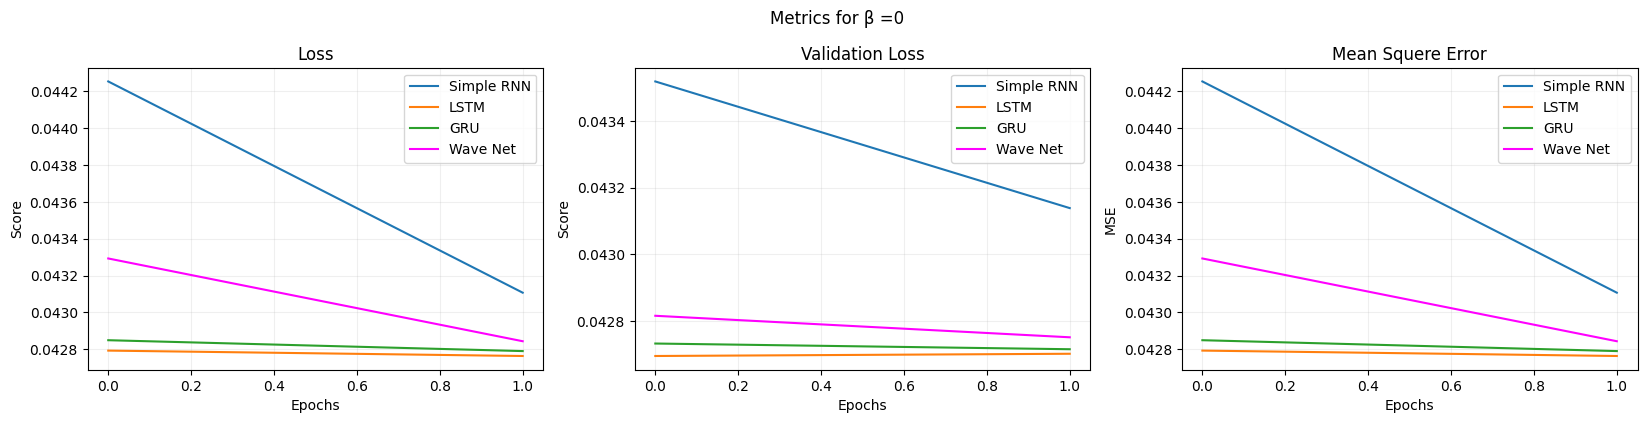

In [22]:
epochs = np.arange(0,len(loss[0]))
plt.figure(figsize=(20, 4),dpi=100)
plt.suptitle('Metrics for β ='+ str(beta[0]),  y=0.98, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)

plt.subplot(1,3,1)
for i in range(len(model)): plt.plot(epochs,loss[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Loss')
#plt.ylim(-0.01,0.2)
plt.grid(alpha=0.2)

plt.subplot(1,3,2)
for i in range(len(model)): plt.plot(epochs,val_loss[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Validation Loss')
#plt.ylim(-0.01,0.13)
plt.grid(alpha=0.2)


plt.subplot(1,3,3)
for i in range(len(model)): plt.plot(epochs,mse[i], label=model_name[i],  color=color[i], linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title("Mean Squere Error")
#plt.ylim(-0.01,0.2)
plt.grid(alpha=0.2)
plt.savefig(f'{path}/1_Metrics_b{beta}_M{model_code}.png')

plt.show()

In [26]:
'''
Aqui iremos alocar a previsão do treinamento, to teste e de ambos em vetores. 
Para o caso dos valores de test eles precisam estar na posição em que o treinamento acaba para que possamos comparar no mesmo dataset
'''

# make predictions
trainPredict, testPredict, trainPredictPlot, testPredictPlot, model_data = [],[],[],[],[]

for i in range(len(model)):
  #Train
  trainPredict.append(model[i].predict(trainX))
  a = np.empty_like(dataset)
  a[:, :] = np.nan
  a[look_back:len(trainPredict[i])+look_back, :] = trainPredict[i]
  trainPredictPlot.append(a)
  #Teste
  testPredict.append(model[i].predict(testX))
  a = np.empty_like(dataset)
  a[:, :] = np.nan
  a[len(trainPredict[i])+(look_back*2)+1:len(dataset)-1, :] = testPredict[i]
  testPredictPlot.append(a)
  #All
  a =  np.empty_like(dataset) #creating a empyt vector
  a[look_back:len(trainPredict[i])+look_back, :] = trainPredict[i] #alocating the the traint data generatead by the model
  a[len(trainPredict[i])+(look_back*2)+1:len(dataset)-1, :] = testPredict[i] #alocating the the test data generatead by the model
  a = (np.reshape(a,(len(a))))
  a[:look_back] = np.nan
  #model_data = model_data[look_back:]
  # Killing divergences
  for k in range(len(a)):
      if a[k] > 1: a[k] = np.nan
      #if a[i] < 0.0001: a[i] = 0
  model_data.append(a)
del a

TRAIN Simple RNN DONE
TEST Simple RNN DONE
ALL Simple RNN DONE
TRAIN LSTM DONE
TEST LSTM DONE
ALL LSTM DONE
TRAIN GRU DONE
TEST GRU DONE
ALL GRU DONE


ValueError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


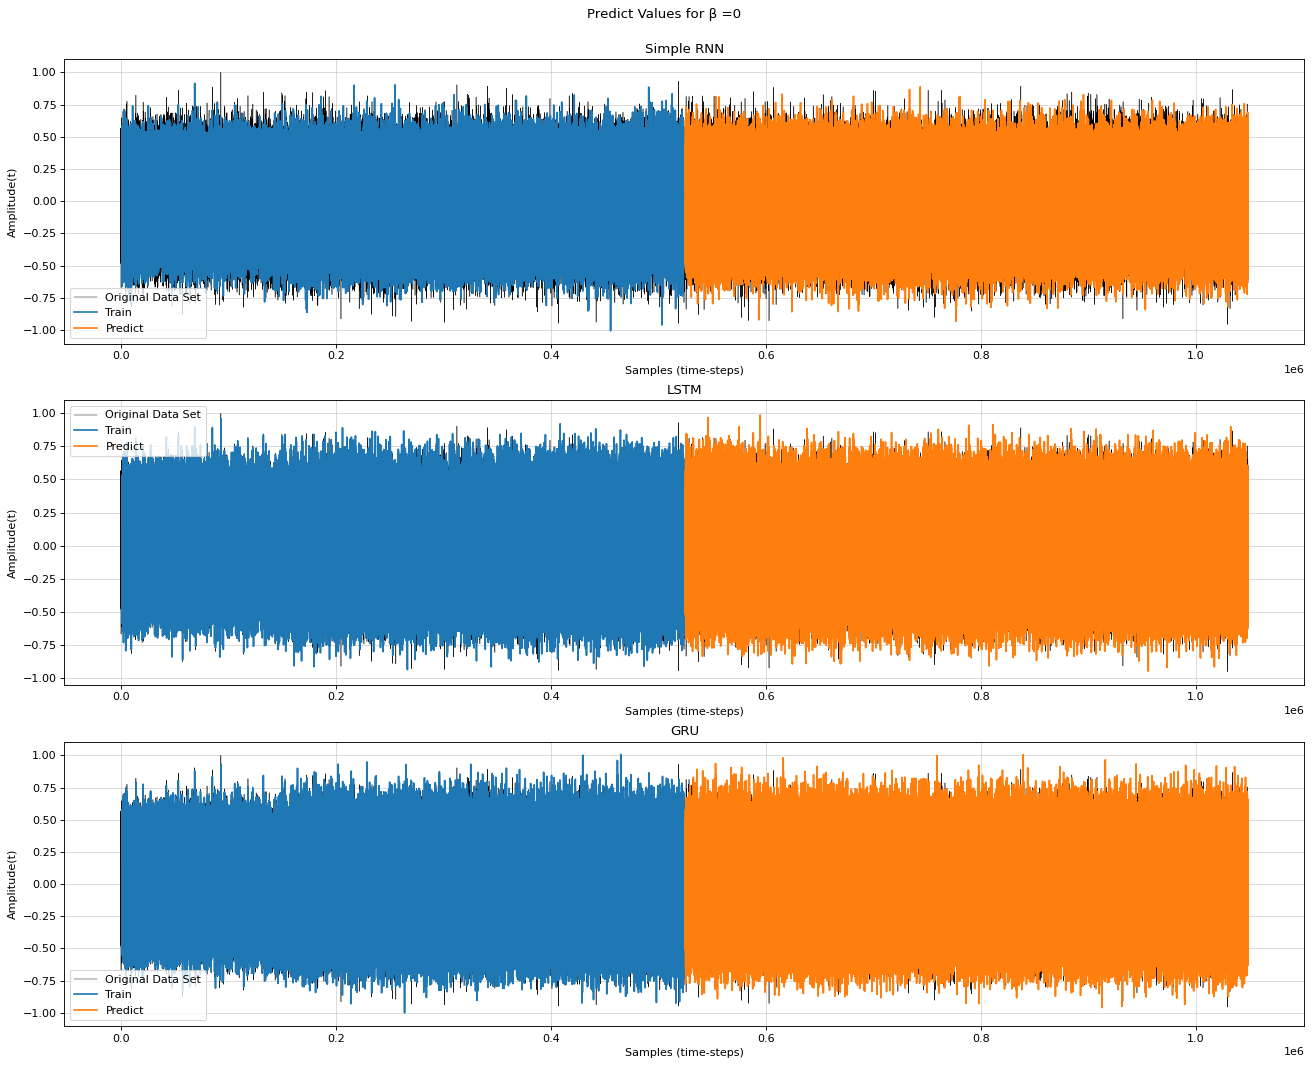

In [ ]:
if   beta == '0': df_color = 'black'
elif beta == '1': df_color = 'magenta'
else            : df_color = 'red'

grossura = 0.4 if beta== '0' else 1

plt.figure(figsize = (20,4*len(model)+4), dpi=80)
plt.suptitle('Predict Values for β ='+ str(beta[0]),  y=0.91, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
for i in range(len(model)):
  plt.subplot(len(model),1,(i+1))
  plt.plot(dataset,label="Original Data Set",color = df_color,linewidth=grossura)
  plt.plot(trainPredictPlot[i],label='Train',color='C0')
  plt.plot(testPredictPlot[i],label='Predict',color='C1')
  plt.title(str(model_name[i]))
  plt.ylabel('Amplitude(t)')
  plt.xlabel('Samples (time-steps)')
  plt.legend()
  plt.grid(alpha=0.5)
plt.savefig(f'{path}/2_Predict_b{beta}_M{model_code}.png')
plt.show()

## Auto Prediction 

Now we will create a function to automatica generate new data. The model will predeict a value and the will add this value in the incial vector to be predict and erase the incial point

```
x = [1,2,3,4]
y = model.predic(x) # y = 5
x.append(y)
x = x[1:] 
x = [2,3,4,5]
```

the we star again saving all values of `y`



In [ ]:
def autoGen(data,output_size=10,n_features=1,model_type=model[0]): 
  lst_output = []                                      # Empty Vector   
  model = model_type                                   # Alocatin the Model
  #data = list(dataset[-(look_back+1):,:])             # Alocating data as a list ?                                       
  data = list(data)                                    #   "   "    
  for i in range(0,output_size):                       # Iniciating the loop for output_size stop point                  
    x_input=np.array(list(data)[1:])                   # Inputad data in a numpy format                       
    x_input = x_input.reshape(1, n_features,look_back) # Reshapping the vector [??????????]                                        
    yhat = model.predict(x_input, verbose=0)           # Predictin the next value for the model                                 
    lst_output.append(yhat[0][0])                      # Saving the predicted Values                   
    data.append(np.array([lst_output[-1]]))            # Alocating the last value of the predictd vector                              
    data = data[1:]                                    # redefining the data incial vector       
  return lst_output                                    # print the output value

In [ ]:
dat = dataset[-(look_back+1):,:]
i = 0
predict = []
for i in range(len(model)):
    predict.append(autoGen(dat,10*look_back,model_type=model[i]))

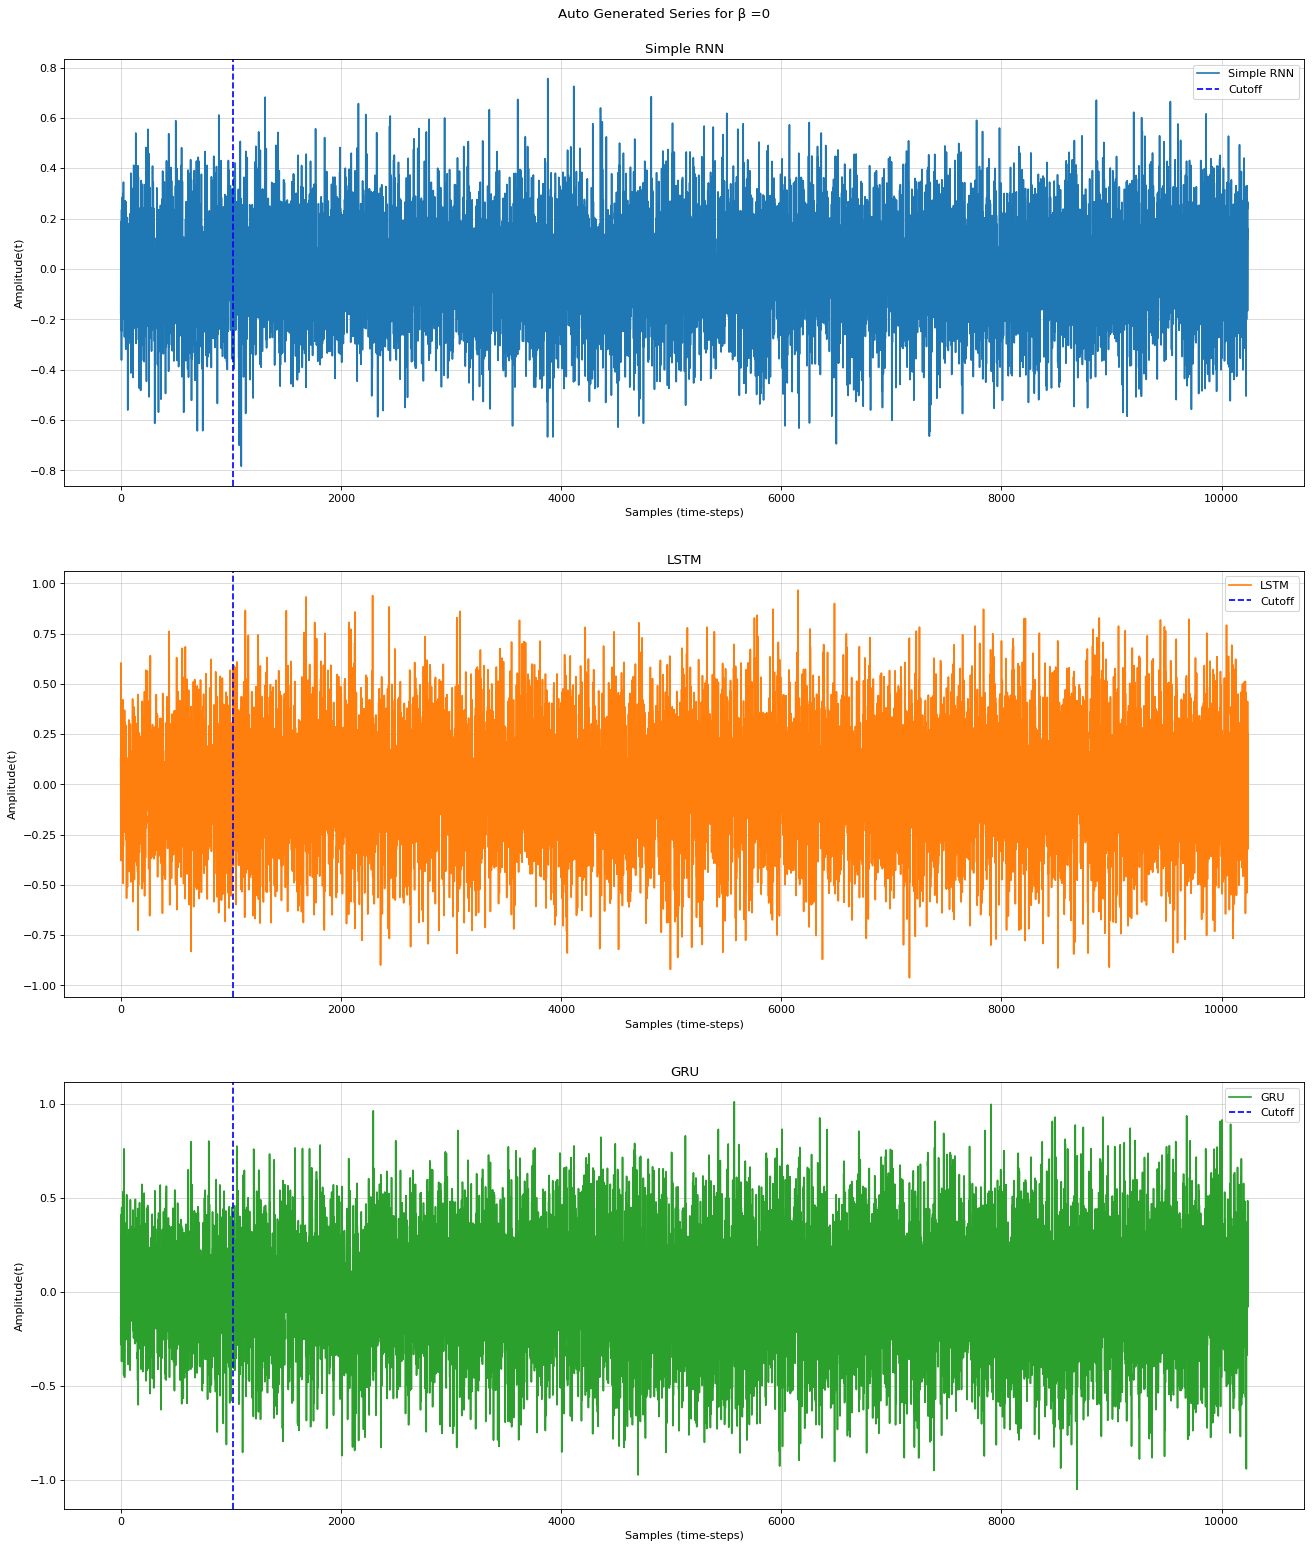

In [ ]:
plt.figure(figsize = (20,4*(len(model)+1)+8), dpi=80)
plt.suptitle('Auto Generated Series for β ='+ str(beta[0]),  y=0.90, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
for i in range(len(model)):
  plt.subplot(len(model),1,i+1)
  plt.plot(predict[i],label=model_name[i],color=color[i])
  plt.axvline(x=look_back,linestyle='--',c='b',label='Cutoff')
  plt.title(str(model_name[i]))
  plt.ylabel('Amplitude(t)')
  plt.xlabel('Samples (time-steps)')
  plt.legend()
  plt.grid(alpha=0.5)
plt.savefig(f'{path}/3_AutoGen_b{beta}_M{model_code}.png')  
plt.show()  

## SpecPlus

Generation of the Power Spectrum of a time series

In [ ]:
def specplus(nomeArquivo,INICIO=10,FIM=6300, textoTituloPSD = r'Original Time Series - ',corPSD2 =  'navy'):
    #FIM = 2**int(np.log2(len(trainPredict[i]))-1)
    import matplotlib.pyplot as plt
    import matplotlib.mlab as mlab
    from scipy import stats, optimize
    import numpy as np
    import math
 
    #---------------------------------------------------------------------
    # Calcula o PSD da série temporal
    #---------------------------------------------------------------------

    def psd(data):
        """Calcula o PSD de uma série temporal."""
        # Define um intervalo para realizar o ajuste da reta
        # INICIO = 15
        # FIM = 6300
        # O vetor com o tempo é o tamanho do número de pontos
        N = len(data)#int(len(data)/2)
        tempo = np.arange(len(data))
        # Define a frequência de amostragem
        dt = (tempo[-1] - tempo[0] / (N - 1))
        fs = 1 / dt
        # Calcula o PSD utilizando o MLAB
        power, freqs = mlab.psd(data, Fs = fs, NFFT = N, scale_by_freq = False)
        # Calcula a porcentagem de pontos utilizados na reta de ajuste
        totalFrequencias = len(freqs)
        totalPSD = FIM - INICIO
        porcentagemPSD = int(100 * totalPSD / totalFrequencias)
        # Seleciona os dados dentro do intervalo de seleção
        xdata = freqs[INICIO:FIM]
        ydata = power[INICIO:FIM]
        # Simula o erro
        yerr = 0.2 * ydata
        # Define uma função para calcular a Lei de Potência
        powerlaw = lambda x, amp, index: amp * (x**index)
        # Converte os dados para o formato LOG
        logx = np.log10(xdata)
        logy = np.log10(ydata)
        # Define a função para realizar o ajuste
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err    
        logyerr = yerr / ydata
        # Calcula a reta de ajuste
        pinit = [1.0, -1.0]
        out = optimize.leastsq(errfunc, pinit, args = (logx, logy, logyerr), full_output = 1)    
        pfinal = out[0]
        covar = out[1]
        index = pfinal[1]
        amp = 10.0 ** pfinal[0]
        indexErr = np.sqrt(covar[0][0])
        ampErr = np.sqrt(covar[1][1]) * amp
        # Retorna os valores obtidos
        return freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM

    def main():
        """Função com o código principal do programa."""
        #print("\nSpectral Analysis for time series...\n")
        # Desabilita as mensagens de erro do Numpy (warnings)
        old_settings = np.seterr(divide = 'ignore', invalid = 'ignore', over = 'ignore')
        # Carrega o arquivo de dados
        #nomeArquivo = 'serie1.txt'     

        pd.DataFrame(nomeArquivo[:2**int(np.log2(len(nomeArquivo)))]).to_csv("data.csv", index=False, header=False)
        #pd.DataFrame(model_data[0][:2**int(np.log2(len(model_data)))]).to_csv("model.csv", index=False, header=False)

        #csv_para_txt
        import csv
        with open("data.txt", "w") as my_output_file: 
            with open("data.csv", "r") as my_input_file: [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
            my_output_file.close()

        data = np.genfromtxt('data.txt',
                             delimiter = ',',
                             dtype = 'float32',
                             filling_values = 0)

        # Exibe os primeiro N valores do arquivo
        #N = 10
        #fig = plt.figure(figsize=(6,4), dpi=100)
        #fig.subplots_adjust(hspace = .4, wspace = .2)
        # Tamanho das fontes
        tamanhoFonteEixoX     = 16
        tamanhoFonteEixoY     = 20
        tamanhoFonteTitulo    = 16
        tamanhoFontePrincipal = 25
        # Título principal
        tituloPrincipal = 'Time Series Spectral Analysis'   
        #-----------------------------------------------------------------
        # Plotagem da série original
        #-----------------------------------------------------------------
        # Define as cores da plotagem
        #corSerieOriginal = cor# 'r'
        # Título dos eixos da série original
        textoEixoX = 'Time'
        textoEixoY = 'Amplitude'
        #textoTituloOriginal = titulo

        #-----------------------------------------------------------------
        # Cálculo e plotagem do PSD                                     --
        #-----------------------------------------------------------------
        # Calcula o PSD
        freqs, power, xdata, ydata, amp, index, powerlaw, INICIO, FIM = psd(data)
        # O valor do beta equivale ao index
        b = index
        # Define as cores da plotagem
        corPSD1 = 'k'
        #corPSD2 =  'orange' if modelo_nome == 'GRU' else 'green'
        #corPSD2 =  'navy'# if nomeArquivo == 'serie_time.txt' else 'orange' if modelo_nome == 'GRU' else 'green'
        # Título dos eixos do PSD
        textoPSDX = 'Frequency (Hz)'
        textoPSDY = 'PSD'
        #textoTituloPSD = r''+str(modelo_nome)+' - PSD Estimation β = '
        # Plotagem do PSD    
        #PSD = fig.add_subplot(2, 2, (1,4))    
        plt.plot(freqs, power, '-', color = corPSD1, alpha = 0.7)
        plt.plot(xdata, ydata, color = corPSD2, alpha = 0.8)
        plt.axvline(freqs[INICIO], color = corPSD2, linestyle = '--')
        plt.axvline(freqs[FIM], color = corPSD2, linestyle = '--')    
        plt.plot(xdata, powerlaw(xdata, amp, index), 'r-', linewidth = 1.5, label = '$%.4f$' %(b))    
        plt.xlabel(textoPSDX                                  )#, fontsize = tamanhoFonteEixoX)
        plt.ylabel(textoPSDY                                  )#, fontsize = tamanhoFonteEixoY)
        plt.title(textoTituloPSD + ' β = %.4f' %(b), loc = 'center')#, fontsize = tamanhoFonteTitulo)
        plt.yscale('log')
        plt.xscale('log')
        plt.grid() 
        #fig.set_size_inches(7, 4)
        #plt.savefig(nomeImagem, dpi = 300, bbox_inches = 'tight', pad_inches = 0.1)    
        #plt.show()

    if __name__ == "__main__":
        main()
    #——————————————————————————————————————————

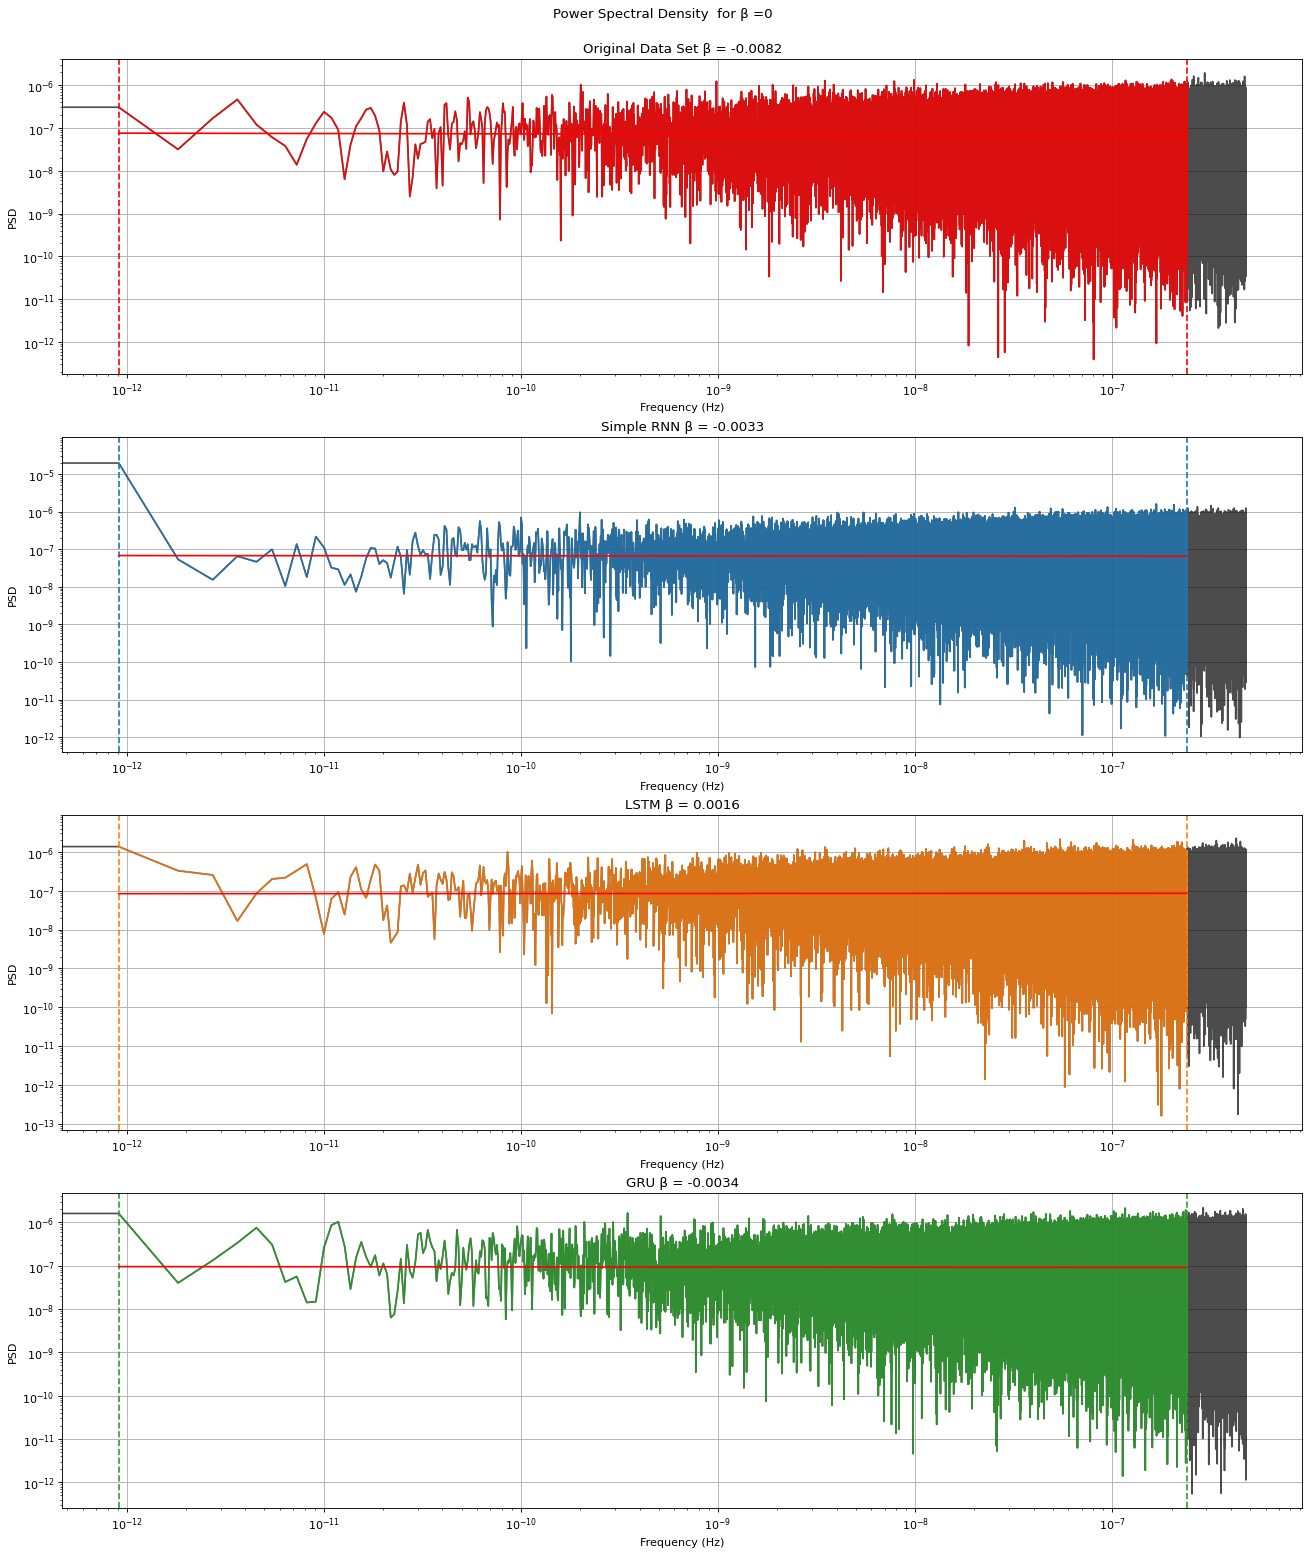

In [ ]:
plt.figure(figsize = (20,4*(len(model)+1)+8), dpi=80)
plt.suptitle('Power Spectral Density  for β ='+ str(beta[0]),  y=0.90, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
plt.subplot(len(model)+1,1,1)
specplus(dataset,         #Dataframe
          1,              #Incial Value
          2**int(np.log2(len(dataset))-2), #Final Value
          'Original Data Set',   #Chat Tile
          'red')           #Color
for i in range(len(model)):
  plt.subplot(len(model)+1,1,i+2)
  specplus(model_data[i],  #Dataframe
           1,              #Incial Value
           2**int(np.log2(len(model_data[i]))-2), #Final Value
           model_name[i],   #Chat Tile
           color[i])        #Color  
plt.savefig(f'{path}/4_PSD_b{beta}_M{model_code}.png')
plt.show()

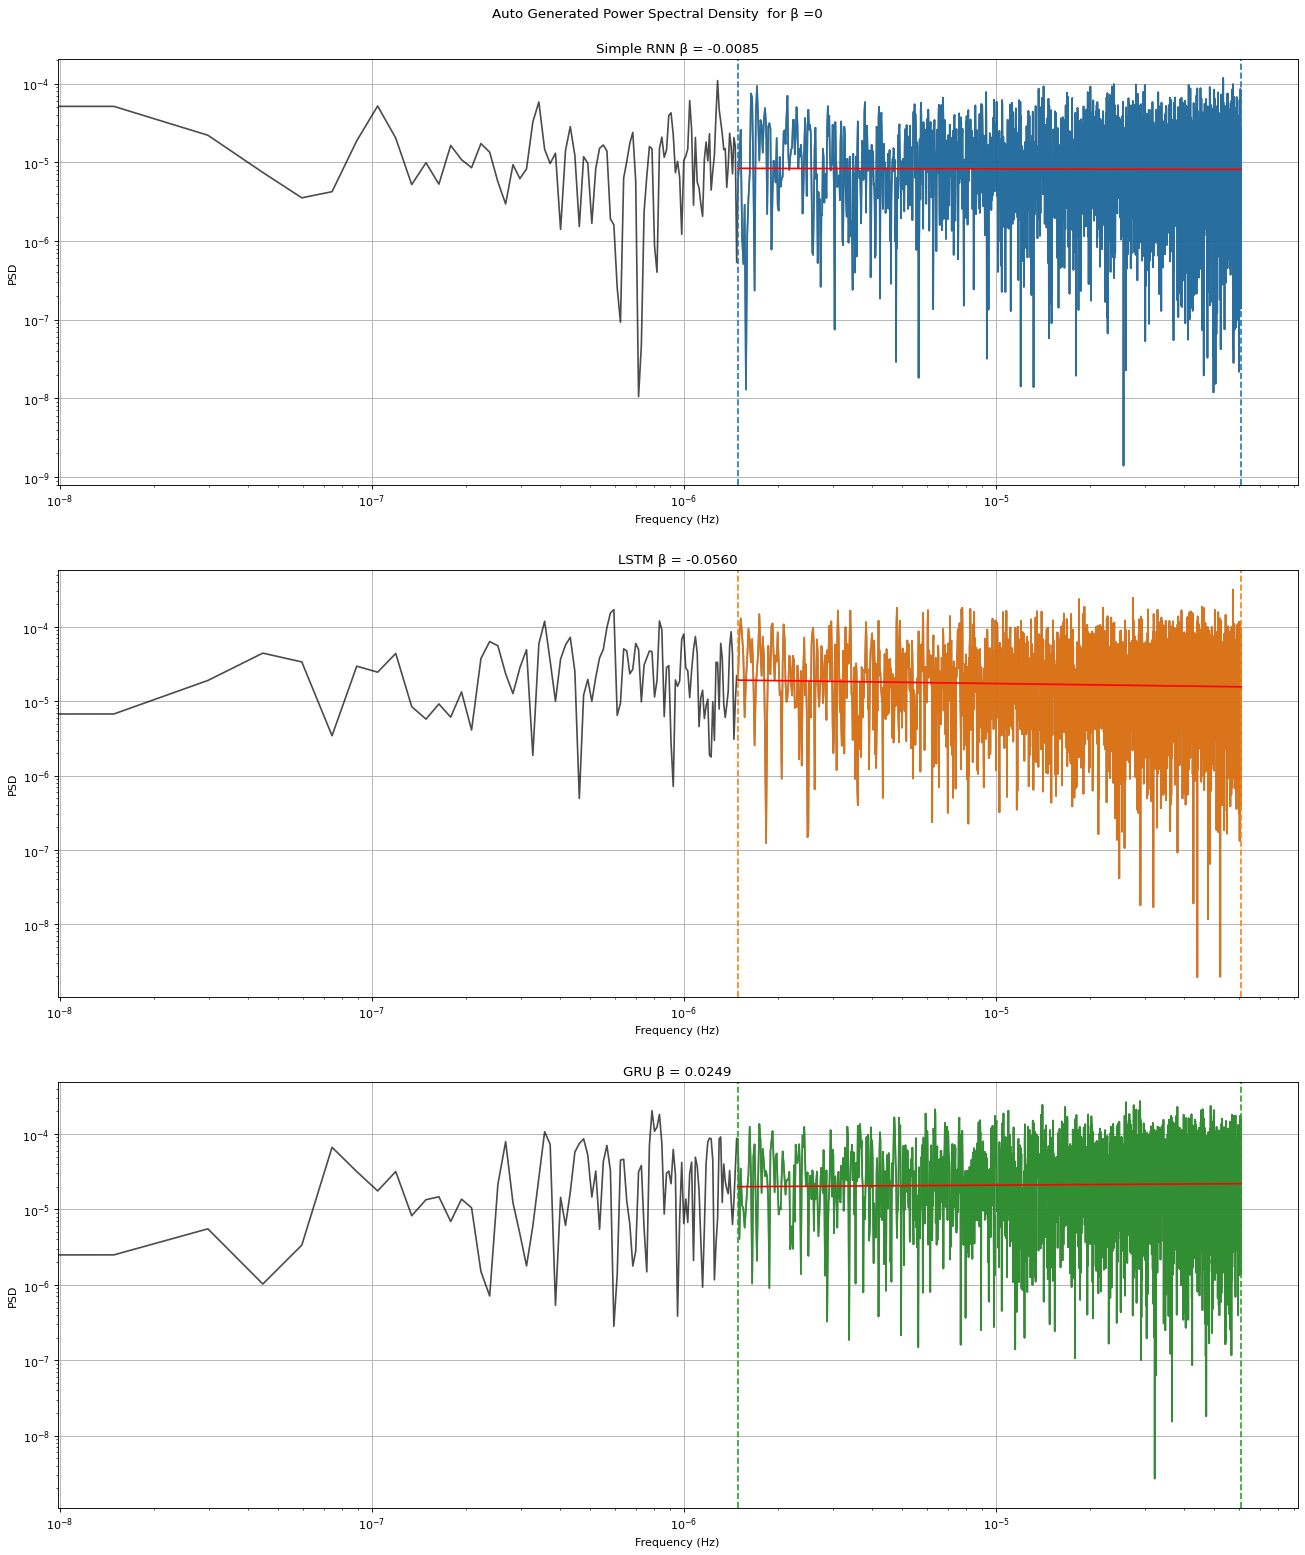

In [ ]:
plt.figure(figsize = (20,4*(len(model)+1)+8), dpi=80)
plt.suptitle('Auto Generated Power Spectral Density  for β ='+ str(beta[0]),  y=0.90, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
for i in range(len(model)):
  plt.subplot(len(model),1,i+1)
  specplus(predict[i][look_back:],  #Dataframe
           100,              #Incial Value
           2**int(np.log2(len(predict[i][look_back:])/2-2)), #Final Value
           model_name[i],   #Chat Tile
           color[i])        #Color
plt.savefig(f'{path}/5_PSD_AutoGen_b{beta}_M{model_code}.png')
plt.show()



In [ ]:
#remove all
#!rm *

In [ ]:
#Ziping Data for download📦
#!zip -r /content/drive/MyDrive/Kaggle/model_RNN.zip /content/model_RNN/
#!zip -r /content/drive/MyDrive/INPE/Qualification.zip /content/drive/MyDrive/INPE/Qualification

# References

https://www.tensorflow.org/guide/keras/save_and_serialize

https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

[Prediction and analysis of COVID-19 positive cases using deep learning models: A descriptive case study of India](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7298499/pdf/main.pdf)

[LSTM Models For Univariate Time Series Forecasting](https://github.com/krishnaik06/Time-Series-Forecasting/blob/master/UnivariateTimeSeries.ipynb)

In [ ]:
end = time.time()


In [ ]:
print('intere program runs in\n',round((end-begin)/60/60,4),' hours')

intere program runs in
 2.1052  hours
